# Augur for Influenza A - HA protein

In [1]:
import json

## Metadata is required -- Piece metadata file together

In [3]:
## Metadata is required

# Making metadata by parsing FASTA

from Bio import SeqIO
import re


records = []
for record in SeqIO.parse("../data/fluHA_sequences-with-metadata.fasta", "fasta"):
    records.append(record.description)

    
# Split description
split = []
for record in records:
    split.append(record.split('|'))

# Grab metadata from split description    
strainsList = []
idList = []
dateUnsplit = []
countryList = []
stateList = []
for item in split:
    strainsList.append(item[0])
    idList.append(item[1])
    dateUnsplit.append(item[2])
    countryList.append(item[3])
    stateList.append(item[4])

### Testing my regular expressions

In [4]:
testSearch = re.compile('(?P<strain>^[A-Z]+.*)')

testString = 'A/Boston/12/2007|CY044484|12/04/2007|USA|Massachusetts'

test = testString.split('|')


# t = testSearch.search(testString)
# id = t.group('strain')
# test.append(id)

# for record in records:
#     t = testSearch.search(record)
#     id = t.group('strain')
#     test.append(id)

# counter = 0
# for item in dateUnsplit:
#     if len(item) == 4:
#         print("yes")
#         counter += 1
#     elif len(item) == 10:
#         print("yes")
#         counter += 1
#     else:
#         print("no")
#         print(counter)


# print(test)
# for item in test:
#     print(item)
# print(len(test))
        
#     print(len(item))
# print(len(dateUnsplit[7]))

### Get dates from fasta.description

In [7]:
# Get dates
dateSearch = re.compile('(?P<month>\d{2})[/](?P<day>\d{2})[/](?P<year>\d{4}$)')
yearSearch = re.compile('(?P<year>\d{4}$)')
monthYearSearch = re.compile('(?P<month>\d{2})[/](?P<year>\d{4}$)')
monthList = []
dayList = []
yearList = []
for item in dateUnsplit:
    if len(item) == 4:
        y = yearSearch.search(item)
        year = y.group('year')
        yearList.append(year)
        monthList.append('XX')
        dayList.append('XX')
    elif len(item) == 10:
        d = dateSearch.search(item)
        month = d.group('month')
        day = d.group('day')
        year = d.group('year')
    
        monthList.append(month)
        dayList.append(day)
        yearList.append(year)
    elif len(item) == 7:
        d = monthYearSearch.search(item)
        month = d.group('month')
        year = d.group('year')
    
        monthList.append(month)
        dayList.append("XX")
        yearList.append(year)

        
dateList = []
index = 0
for i in range(len(dateUnsplit)):
    dateList.append(yearList[i] + '-' + monthList[i] + '-' + dayList[i])
    index += 1

### Combine ID and strains to create unique identifiers

In [8]:
# Concatenate strain strings with id strings for unique identifiers
newID = []
counter = 0
for id in idList:
    newID.append(id + "|" + strainsList[counter])
    
    # Remove spaces
#     if " " in newID[counter]:
#         newID[counter] = newID[counter].replace(" ", "")
    counter += 1


### Create new fasta file to replace IDs with the new ones

In [9]:
from Bio import SeqIO

original_file = r"../data/fluHA_sequences-with-metadata.fasta"
corrected_file = r"../data/corrected.fasta"

position = 0
with open(original_file) as original, open(corrected_file, 'w') as corrected:
    records = SeqIO.parse(original_file, 'fasta')
    for record in records:
#         print(record.id)
        record.id = newID[position]
        record.description = newID[position]
        position += 1
#         print(record.id)             
        SeqIO.write(record, corrected, 'fasta')

### Write metadata.tsv file

In [10]:
import pandas as pd

# metadata_id = list(zip(fasta_ids, strainsList, yearsList))
# metadata = list(zip(idList, strainsList, yearsList))
metadata = list(zip(newID, dateList))

# df = pd.DataFrame(data = metadata, columns=['id', 'strain', 'year'])
df = pd.DataFrame(data = metadata, columns=['strain', 'date'])

df.to_csv('../data/metadata.tsv',sep='\t',index=False,header=True)

## How many sequences do we have per year?

In [71]:
from plotnine import *
import pandas as pd

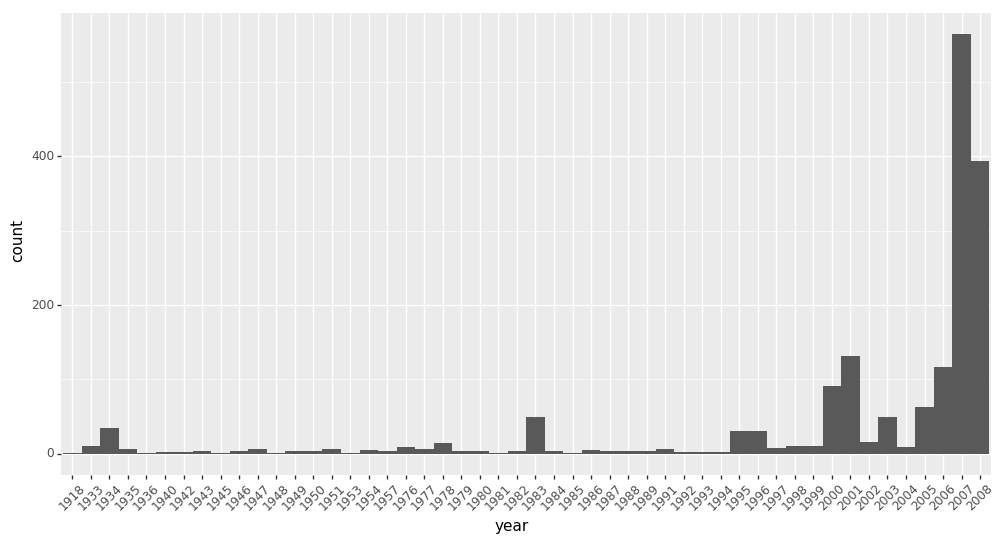

<ggplot: (8782363559870)>


In [84]:
# Write a dictionary counter for seqs in each year

countseq = {}
for year in yearList:
    if year not in countseq:
        countseq[year] = 1
    else:
        countseq[year] += 1

countList = []
for item in countseq.items():
    countList.append(item)
    
dfCount = pd.DataFrame(data = countList, columns = ['year','count'])
dfCount = dfCount.sort_values(by=['year'])

# Drop 2007 and 2008 since they're so much bigger
dfDrop = dfCount.drop([3, 4])

# Plot with all years
plot1 = (ggplot(dfCount, aes('year', 'count')) 
+ geom_bar(stat='identity', width = 1)) + plotnine.theme(figure_size=(12, 6), axis_text_x = element_text(angle = 45))
print(plot1)



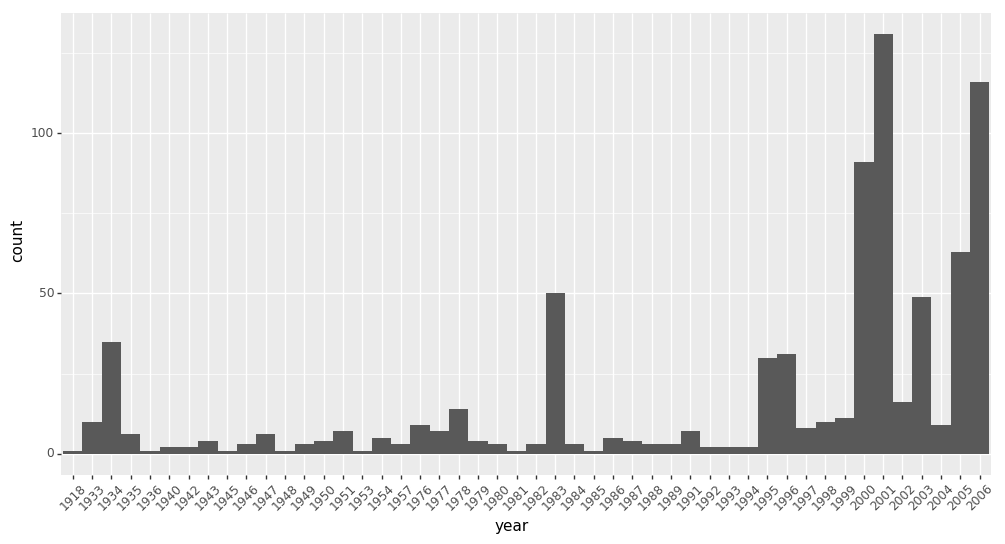

<ggplot: (8782363626297)>


In [83]:
# Plot without 2007 and 2008
plot2 = (ggplot(dfDrop, aes('year', 'count')) 
+ geom_bar(stat='identity', width = 1)) + plotnine.theme(figure_size=(12, 6), axis_text_x = element_text(angle = 45))
print(plot2)

## Clean trees - Remove suspected swine flu
### Write dropped_strains.txt

In [25]:
dropped_list = ["S62154|A/Alma_Ata/1417/84", "CY039991|A/New_Jersey/8/1976", "CY178719|A/Wisconsin/301/1976", "CY147422|A/New_Jersey/Wistar/1976", "CY177464|A/Wisconsin/263/1976", "FJ986620|A/Ohio/01/2007","CY039909|A/Maryland/12/1991" "CY021957|A/New_Jersey", "CY044365|A/New_Jersey/11/1976", "CY130118|A/New_Jersey/8/1976", "CY024925|A/Ohio/3559/1988", "CY026139|A/Wisconsin/301/1976", "U53162|A/Wisconsin/4754/1994", "U53163|A/Wisconsin/4755/1994"]

with open("../config/dropped_strains.txt", "w") as dropped_strains:
    for strain in dropped_list:
        dropped_strains.write(strain + "\n")

## Tree with 2 sequences per group
### Filter

In [26]:
!mkdir -p ../results/

!augur filter \
  --sequences ../data/corrected.fasta \
  --metadata ../data/metadata.tsv \
  --exclude ../config/dropped_strains.txt \
  --output ../results/filtered-2.fasta \
  --group-by year \
  --sequences-per-group 2 \
  --min-date 1918

### Align

In [23]:
!augur align \
  --sequences ../results/filtered-2.fasta \
  --output ../results/aligned-2.fasta 


using mafft to align via:
	mafft --reorder --anysymbol --thread 1 ../results/filtered-2.fasta 1> ../results/aligned-2.fasta 2> ../results/aligned-2.fasta.log 

	Katoh et al, Nucleic Acid Research, vol 30, issue 14
	https://doi.org/10.1093%2Fnar%2Fgkf436



Tree takes 0.82 seconds to build

### Tree

In [24]:
!augur tree \
  --alignment ../results/aligned-2.fasta \
  --output ../results/tree_raw-2.nwk

Building a tree via:
	iqtree -ninit 2 -n 2 -me 0.05 -nt 1 -s ../results/aligned-2-delim.fasta -m GTR > ../results/aligned-2-delim.iqtree.log
	Nguyen et al: IQ-TREE: A fast and effective stochastic algorithm for estimating maximum likelihood phylogenies.
	Mol. Biol. Evol., 32:268-274. https://doi.org/10.1093/molbev/msu300

Building original tree took 0.6628730297088623 seconds


### View

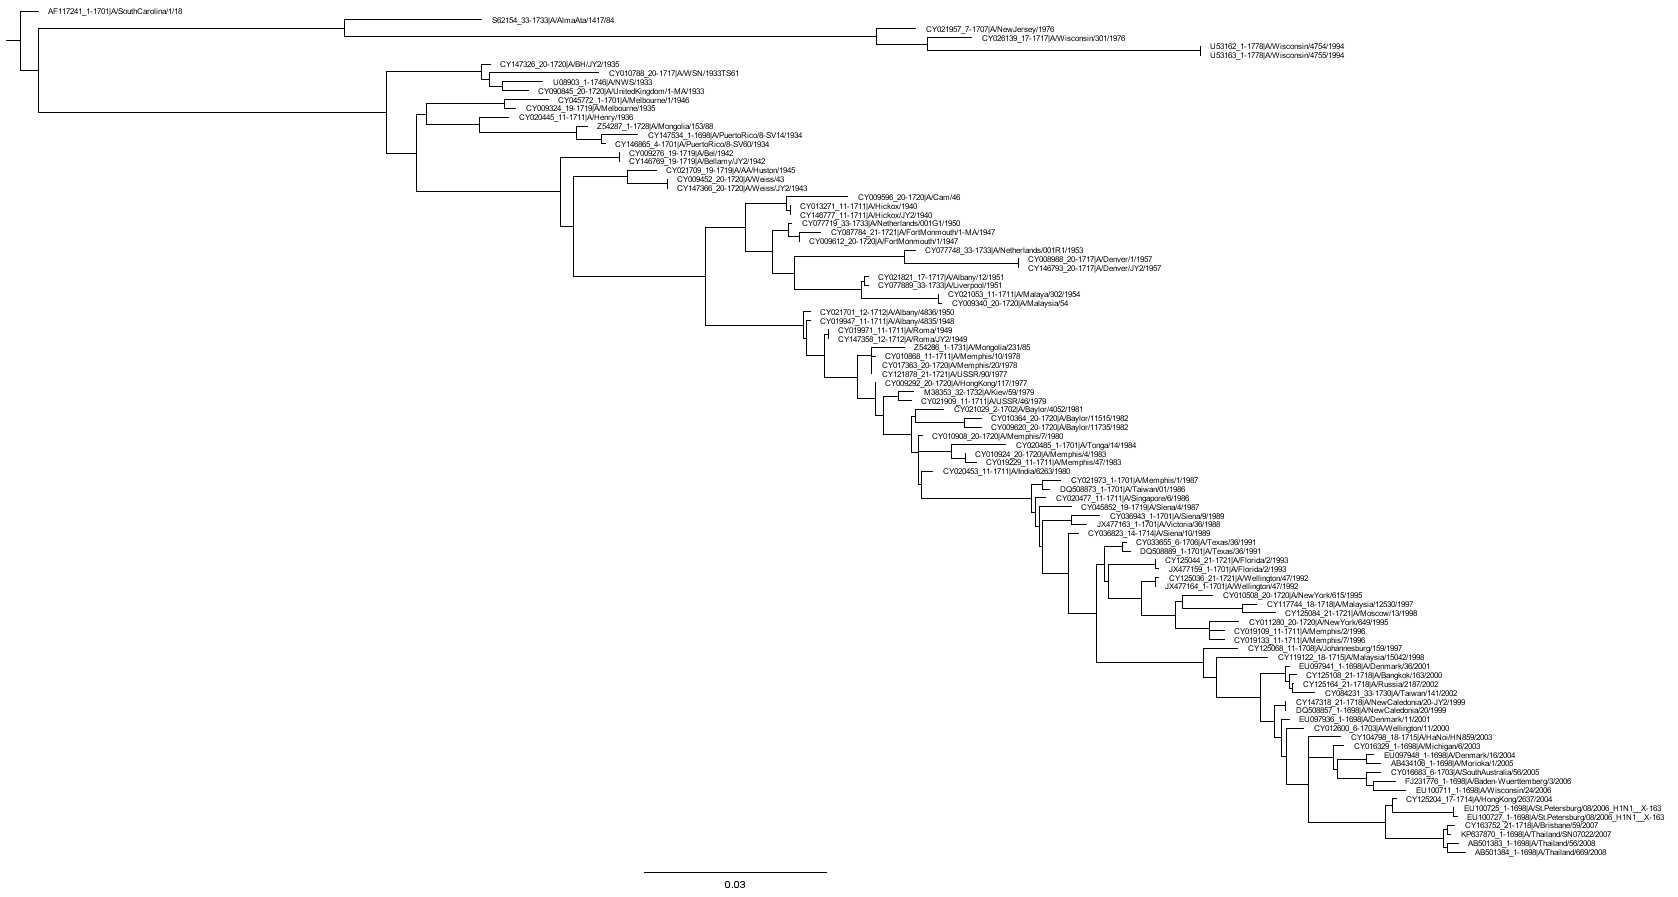

In [4]:
from IPython.display import Image
Image("../results/2019-02-11_tree_raw-2.png")

## Tree with 5 sequences per group
### Filter

In [7]:
!mkdir -p ../results/

!augur filter \
  --sequences ../data/corrected.fasta \
  --metadata ../data/metadata.tsv \
  --exclude None \
  --output ../results/filtered-5.fasta \
  --group-by year \
  --sequences-per-group 5 \
  --min-date 1918

### Align

In [8]:
!augur align \
  --sequences ../results/filtered-5.fasta \
  --output ../results/aligned-5.fasta 


using mafft to align via:
	mafft --reorder --anysymbol --thread 1 ../results/filtered-5.fasta 1> ../results/aligned-5.fasta 2> ../results/aligned-5.fasta.log 

	Katoh et al, Nucleic Acid Research, vol 30, issue 14
	https://doi.org/10.1093%2Fnar%2Fgkf436



Tree takes 2.04 seconds to build

### Tree

In [9]:
!augur tree \
  --alignment ../results/aligned-5.fasta \
  --output ../results/tree_raw-5.nwk

Building a tree via:
	iqtree -ninit 2 -n 2 -me 0.05 -nt 1 -s ../results/aligned-5-delim.fasta -m GTR > ../results/aligned-5-delim.iqtree.log
	Nguyen et al: IQ-TREE: A fast and effective stochastic algorithm for estimating maximum likelihood phylogenies.
	Mol. Biol. Evol., 32:268-274. https://doi.org/10.1093/molbev/msu300

Building original tree took 2.038604736328125 seconds


### View

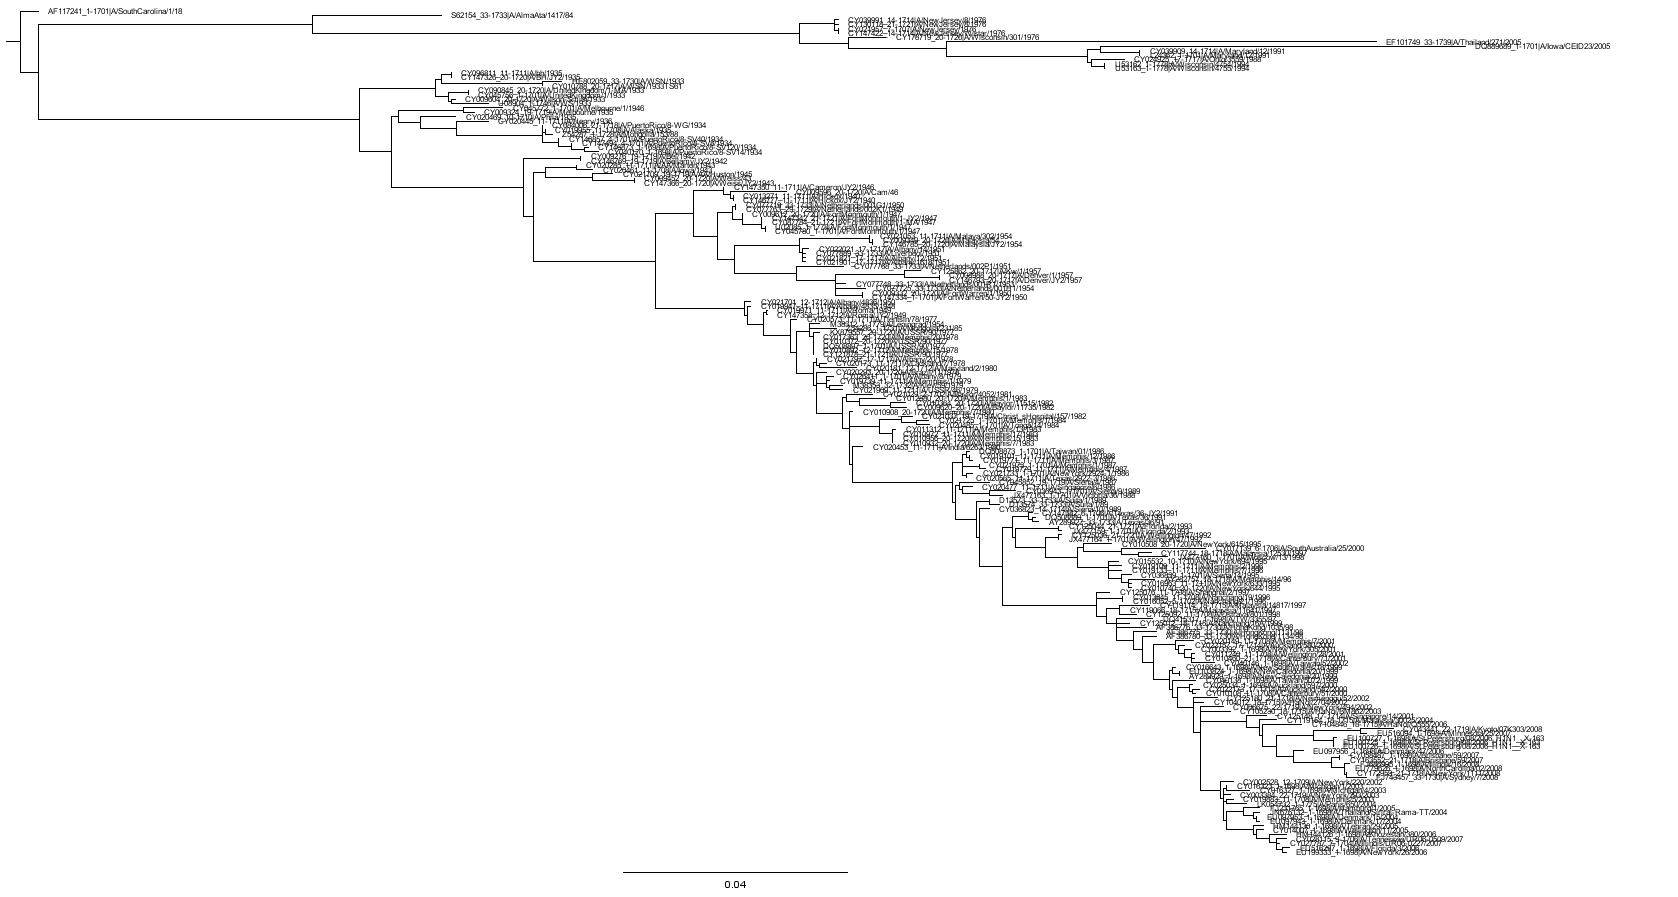

In [3]:
from IPython.display import Image
Image("../results/2019-02-11_tree_raw-5.png")

## Tree with 10 sequences per group
### Filter

In [11]:
!mkdir -p ../results/

!augur filter \
  --sequences ../data/corrected.fasta \
  --metadata ../data/metadata.tsv \
  --exclude None \
  --output ../results/filtered-10.fasta \
  --group-by year \
  --sequences-per-group 10 \
  --min-date 1918

### Align

In [12]:
!augur align \
  --sequences ../results/filtered-10.fasta \
  --output ../results/aligned-10.fasta 


using mafft to align via:
	mafft --reorder --anysymbol --thread 1 ../results/filtered-10.fasta 1> ../results/aligned-10.fasta 2> ../results/aligned-10.fasta.log 

	Katoh et al, Nucleic Acid Research, vol 30, issue 14
	https://doi.org/10.1093%2Fnar%2Fgkf436



Tree takes 2.98 seconds to build

### Tree

In [13]:
!augur tree \
  --alignment ../results/aligned-10.fasta \
  --output ../results/tree_raw-10.nwk

Building a tree via:
	iqtree -ninit 2 -n 2 -me 0.05 -nt 1 -s ../results/aligned-10-delim.fasta -m GTR > ../results/aligned-10-delim.iqtree.log
	Nguyen et al: IQ-TREE: A fast and effective stochastic algorithm for estimating maximum likelihood phylogenies.
	Mol. Biol. Evol., 32:268-274. https://doi.org/10.1093/molbev/msu300

Building original tree took 2.984182834625244 seconds


### View

In [14]:
from ete3 import Tree


tree_raw = Tree("../results/tree_raw-10.nwk")
print(tree_raw)


   /-J02176_1-1775|A/WSN/1933
  |
  |   /-CY010788_20-1717|A/WSN/1933TS61
  |--|
  |   \-HE802059_33-1730|A/WSN/1933
  |
  |   /-CY034132_6-1703|A/WSN/1933
  |  |
  |  |   /-DQ508905_1-1698|A/Wilson-Smith/1933
  |  |  |
  |  |  |      /-CY096811_11-1711|A/bh/1935
  |  |  |   /-|
  |  |  |  |   \-CY147326_20-1720|A/BH/JY2/1935
  |  |  |  |
  |  |  |  |            /-U08903_1-1746|A/NWS/1933
--|  |  |  |         /-|
  |  |  |  |      /-|   \-U08904_1-1746|A/WS/1933
  |  |  |  |     |  |
  |  |  |  |   /-|   \-CY009604_20-1720|A/Wilson-Smith/1933
  |  |  |  |  |  |
  |  |  |  |  |  |   /-CY090845_20-1720|A/UnitedKingdom/1-MA/1933
  |  |  |  |  |   \-|
  |  |  |  |  |      \-CY045756_1-1701|A/UnitedKingdom/1/1933
  |  |  |  |  |
  |  |  |  |  |                                 /-CY019955_11-1708|A/Alaska/1935
  |  |  |  |  |                              /-|
  |  |  |  |  |                             |   \-Z54287_1-1728|A/Mongolia/153/88
  |  |  |  |  |                           /-|
  |  | 

## Augur refine

In [1]:
!grep "CY021709" ../data/corrected.fasta

>CY021709|A/AA/Huston/1945


In [3]:
!augur refine \
  --tree ../results/tree_raw-2.nwk \
  --alignment ../results/aligned-2.fasta \
  --metadata ../data/metadata.tsv \
  --output-tree ../results/tree.nwk \
  --output-node-data ../results/branch_lengths.json \
  --timetree \
  --coalescent opt \
  --date-confidence \
  --date-inference joint 
#   --clock-filter-iqd 4


0.14	***WARNING: TreeAnc._attach_sequences_to_nodes: NO SEQUENCE FOR LEAF: CY021709_19-1719|A/AA/Huston/1945

0.14	***WARNING: TreeAnc._attach_sequences_to_nodes: NO SEQUENCE FOR LEAF: CY009452_20-1720|A/Weiss/43

0.14	***WARNING: TreeAnc._attach_sequences_to_nodes: NO SEQUENCE FOR LEAF: CY147366_20-1720|A/Weiss/JY2/1943

0.14	***WARNING: TreeAnc._attach_sequences_to_nodes: NO SEQUENCE FOR LEAF: CY009276_19-1719|A/Bel/1942

0.14	***WARNING: TreeAnc._attach_sequences_to_nodes: NO SEQUENCE FOR LEAF: CY146769_19-1719|A/Bellamy/JY2/1942

0.14	***WARNING: TreeAnc._attach_sequences_to_nodes: NO SEQUENCE FOR LEAF: CY045772_1-1701|A/Melbourne/1/1946

0.14	***WARNING: TreeAnc._attach_sequences_to_nodes: NO SEQUENCE FOR LEAF: CY009324_19-1719|A/Melbourne/1935

0.14	***WARNING: TreeAnc._attach_sequences_to_nodes: NO SEQUENCE FOR LEAF: CY020445_11-1711|A/Henry/1936

0.15	***WARNING: TreeAnc._attach_sequences_to_nodes: NO SEQUENCE FOR LEAF: Z54287_1-1728|A/Mongolia/153/88

0.15	***WARNING: TreeAnc

It appears that the name of the strains changed for some reason

in tree_raw-2.nwk: CY021709_19-1719|A/AA/Huston/1945
in aligned-2.fasta: CY021709:19-1719|A/AA/Huston/1945

`augur filter` introduces the ":19-1719" part when I run it here, but not in the zika tutorial

1. Why is ":19-1719" being added to my sequence IDs?
2. Why is the **":"** turned into a **"_"** when I make my tree?